### Reservoir Computing

In [1]:
import numpy as np
import scipy as sp
import networkx as nx
from sklearn import linear_model

from my_attractors import *

import matplotlib.pyplot as plt
import ipywidgets.widgets as widget

In [2]:
X = np.load("lorenz63_sim_data_e3_3.npy")
X.shape

(10000, 3)

In [3]:
# Creating the Reservoir - RNN

n = 500
p = 0.01
network = nx.fast_gnp_random_graph(n,p,seed = 102)
network = nx.to_numpy_array(network,dtype = float)
network.shape

(500, 500)

In [4]:
# Varying connections b/w [-1,1]

rng = np.random.default_rng(101)
network = np.multiply(network, rng.random(size = network.shape)*2 - 1)
network.shape

(500, 500)

In [5]:
# Scaling Spectral Radius; 0.4 for Lorenz

s = 0.4

K = sp.sparse.coo_matrix(network)
evals = sp.sparse.linalg.eigs(K,k = 1,v0 = np.ones(n),return_eigenvectors=False)

A = network * s/np.max(np.abs(evals))
A.shape

(500, 500)

In [6]:
rng2 = np.random.default_rng(101)
W_in = rng.uniform(low = -0.1, high = 0.1,size = (n,3))
W_in.shape

(500, 3)

In [7]:
steps = 6000
disc = 1000
R = np.zeros((n,steps))
#R[:,i] ->  ri
R.shape

(500, 6000)

In [8]:
assert steps < len(X)
for i in range(steps-1):
    R[:,i+1] = np.tanh(A@R[:,i] + W_in @ X[i])
R = R[:,disc:]
#R = R[:,100:]
R.shape

(500, 5000)

In [9]:
# Target Matrix
Y = X[disc:steps,:]
Y

array([[-6.33985311, -3.05514555, 28.73733893],
       [-5.73469948, -2.9739175 , 27.59727962],
       [-5.23676753, -3.01873502, 26.48245171],
       ...,
       [-1.17053279, -4.30576784, 24.53969549],
       [-1.74075332, -4.33905854, 23.38856037],
       [-2.22138212, -4.45647292, 22.34406387]], shape=(5000, 3))

In [10]:
reg = linear_model.Ridge(alpha = 1e-8,fit_intercept=True)
reg.fit(R.T,Y)
W_out = reg.coef_.T
W_out.shape

(500, 3)

In [11]:
#R.T@W_out
np.isclose(R.T@W_out,Y,atol=1e-1).all()

np.True_

In [12]:
# Predicting the Time Series
trained = steps - disc
predict = 1000

#Adding Fitted Data
l = min(len(X),steps + predict)
X_true = X[disc:l]

X_rec = np.zeros((trained + predict,3))

X_rec[:steps-disc] = R.T @ W_out

Ri = R[:,-1]
for i in range(steps-disc-1,trained + predict-1):
    Ri = np.tanh(A@Ri + W_in @ X_rec[i])
    X_rec[i+1] = Ri @ W_out

print(X_rec.shape)

(6000, 3)


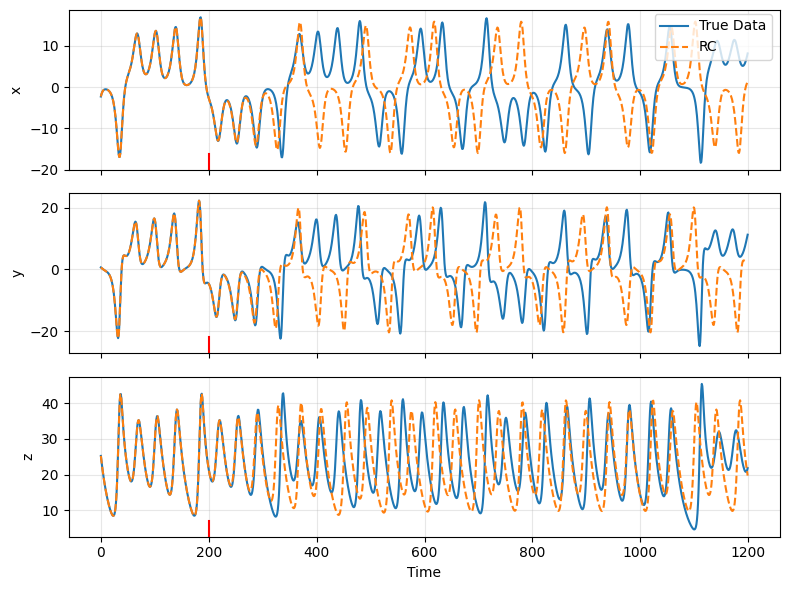

In [17]:
#start,stop = 4_500,6_000
f = plotTimeSeries([[X_true[-1200:],{"label" : "True Data"}],[X_rec[-1200:],{"label" : "RC","ls":"--"}]]);
for ax in f.get_axes():
    ax.axvline(200,color = "red",ymax=0.1)

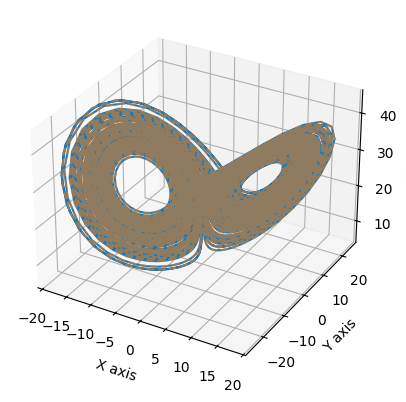

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(*X_true.T)
ax.plot(*X_rec.T,ls = "--",alpha = 0.5)

# Labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


plt.show()

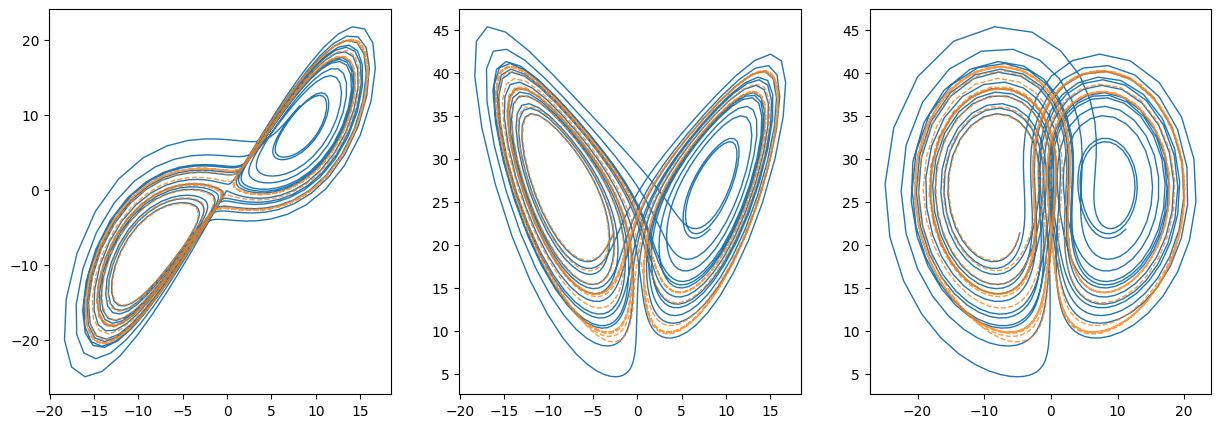

In [65]:
X_t,Y_t,Z_t = X_true[-1000:].T
X_r,Y_r,Z_r = X_rec[-1000:].T

fig = plt.figure(figsize = (15,5))

xy = fig.add_subplot(1,3,1)
xy.plot(X_t,Y_t,lw = 1)
xy.plot(X_r,Y_r,ls = "--",alpha = 0.8,lw = 1)

xz = fig.add_subplot(1,3,2)
xz.plot(X_t,Z_t,lw = 1)
xz.plot(X_r,Z_r,ls = "--",alpha = 0.8,lw = 1)

yz = fig.add_subplot(1,3,3)
yz.plot(Y_t,Z_t,lw = 1)
yz.plot(Y_r,Z_r,ls = "--",alpha = 0.8,lw = 1)

plt.show()